# DeepGuard

# Installazioni e Import principali

In [ ]:
!pip install imageio
!pip install jsonpickle
!pip install opencv-python
!pip install pyglet
!pip install seaborn
!pip install scikit-learn
!pip install stable_baselines3
!pip install tensorboard
!pip install torchvision
!pip install tqdm


In [ ]:
!pip install Gymnasium
!pip install numpy
!pip install matplotlib
!pip install torch
!pip install --no-deps gym-idsgame
!pip install gym

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from collections import deque, namedtuple
from typing import Dict, Any, List, Tuple
from abc import ABC, abstractmethod
from datetime import datetime
from tqdm import tqdm
import time

from gym_idsgame.envs import (
    IdsGameRandomAttackV0Env,
    IdsGameRandomAttackV1Env,
    IdsGameRandomAttackV2Env,
    IdsGameRandomAttackV3Env,
    IdsGameRandomAttackV21Env
)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:
%matplotlib inline
plt.style.use('ggplot')

# Config

In [ ]:
config = {
    "seed": 42,
    "sarsa_agent": {
        "num_episodes": 10000,
        "max_steps_per_episode": 100,
        "alpha_start": 0.001,
        "alpha_decay": 0.9995,
        "alpha_min": 0.0001,
        "gamma": 0.99,
        "epsilon_start": 1.0,
        "epsilon_decay": 0.9995,
        "epsilon_min": 0.01,
        "evaluation_frequency": 1000,
        "evaluation_episodes": 100,
    },
    "ddqn": {
        "num_episodes": 1000,
        "gamma": 0.99,
        "tau": 0.005,
        "lr": 0.0001,
        "memory_size": 50000,
        "batch_size": 64,
        "epsilon_start": 1.0,
        "epsilon_decay": 0.9995,
        "epsilon_min": 0.05,
    },
}

In [ ]:
# Set random seeds for reproducibility
random.seed(config['seed'])
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config['seed'])

print(f"(Seed: {config['seed']}).")

(Seed: 42).


# Compatibilità tra vecchia e nuova API Gym

In [ ]:
class IDSGameWrapper:
    def __init__(self, env):
        self.env = env
        self.attacker_action_space = env.attacker_action_space
        self.defender_action_space = env.defender_action_space
        self.action_space = self.defender_action_space

    def reset(self, seed=None):
        if seed is not None and hasattr(self.env, 'seed'):
            self.env.seed(seed)
        res = self.env.reset()
        return res[1] if isinstance(res, tuple) else res

    def step(self, defender_action):
        max_action = self.defender_action_space.n - 1
        defender_action = min(defender_action, max_action)

        res = self.env.step((-1, defender_action))

        if len(res) == 4:
            obs, reward, done, info = res
        elif len(res) == 5:
            obs, reward, terminated, truncated, info = res
            done = terminated or truncated

        if isinstance(obs, tuple):
            obs = obs[1]
        if isinstance(reward, tuple):
            reward = reward[1]

        return obs, reward, done, info

    def close(self):
        self.env.close()

In [ ]:
def create_env(version: str) -> IDSGameWrapper:
    env_classes = {
        "V0": IdsGameRandomAttackV0Env,
        "V1": IdsGameRandomAttackV1Env,
        "V2": IdsGameRandomAttackV2Env,
        "V3": IdsGameRandomAttackV3Env,
        "V21": IdsGameRandomAttackV21Env,
    }
    if version not in env_classes:
        raise ValueError(f"Unsupported environment version: {version}")

    env_class = env_classes[version]
    env = IDSGameWrapper(env_class())
    return env

# Test Best Env

In [ ]:
test_env = create_env("V21")
print(f"Attacker Action Space: {test_env.attacker_action_space}")
print(f"Defender Action Space: {test_env.defender_action_space}")

Attacker Action Space: Discrete(20)
Defender Action Space: Discrete(20)


In [ ]:
num_episodes = 150
episode_rewards = []
episode_lengths = []

print(f"Testing baseline su {num_episodes} episodi...")

for ep in range(num_episodes):
    obs = test_env.reset(seed=ep)
    ep_reward = 0
    done = False

    for step in range(500):
        action = test_env.action_space.sample()
        obs, reward, done, info = test_env.step(action)
        ep_reward += reward
        if done:
            break

    episode_rewards.append(ep_reward)
    episode_lengths.append(step + 1)

test_env.close()

print("\n--- Risultati Baseline ---")
print(f"Lunghezza media: {np.mean(episode_lengths):.1f} (std: {np.std(episode_lengths):.1f})")
print(f"Reward medio: {np.mean(episode_rewards):.1f} (std: {np.std(episode_rewards):.1f})")
print(f"Obiettivo: Battere un reward di {np.mean(episode_rewards):.1f} e una lunghezza di {np.mean(episode_lengths):.1f}")

Testing baseline su 150 episodi...

--- Risultati Baseline ---
Lunghezza media: 102.0 (std: 0.0)
Reward medio: -100.0 (std: 0.0)
Obiettivo: Battere un reward di -100.0 e una lunghezza di 102.0


In [ ]:
obs = test_env.reset(seed=42)
test_env.close()

print("--- Analisi dello Stato (obs) per il Difensore ---")
print(f"Tipo di Stato: {type(obs)}")
print(f"Forma (Shape) dello Stato: {obs.shape}")
print("\nContenuto dello Stato (Esempio):")
print(obs)

--- Analisi dello Stato (obs) per il Difensore ---
Tipo di Stato: <class 'numpy.ndarray'>
Forma (Shape) dello Stato: (4, 5)

Contenuto dello Stato (Esempio):
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]


# S.A.R.S.A

In [ ]:
def extract_state_features(state_matrix: np.ndarray) -> np.ndarray:
    """
    Estrae un vettore di features 1D (aggregato) da una matrice di stato.
    Questo vettore (chiamato 'phi') è la nostra rappresentazione dello stato.

    Input: state_matrix (forma (4, 5))
    Output: feature_vector (forma (11,))
    """

    features_per_node = state_matrix.sum(axis=1)

    features_per_attribute = state_matrix.sum(axis=0)

    total_vulnerability = np.array([state_matrix.sum()])

    bias = np.array([1.0])

    feature_vector = np.concatenate([
        features_per_node,
        features_per_attribute,
        total_vulnerability,
        bias
    ])

    return feature_vector

In [ ]:
def shape_reward(state: np.ndarray, next_state: np.ndarray,
                 original_reward: float, done: bool, info: dict) -> float:
    """
    Crea un reward "denso" per aiutare l'agente a imparare.
    Questa è la funzione di "reward shaping esterno".
    """
    if done:
        if info.get("hacked", False):
            return -100.0
        else:
            return +50.0


    current_total_vuln = state.sum()
    next_total_vuln = next_state.sum()

    vulnerability_change = next_total_vuln - current_total_vuln

    if vulnerability_change > 0:
        return -1.0
    elif vulnerability_change < 0:
        return +1.0
    else:
        return -0.1

In [ ]:
def get_q_values(state: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """
    Calcola i Q-values per tutte le azioni in un dato stato.
    Q(s, a) = w_a • phi(s)
    """
    features = extract_state_features(state) # (11,)

    q_values = np.dot(weights, features)
    return q_values

In [ ]:
def choose_action(state: np.ndarray, weights: np.ndarray, epsilon: float) -> int:
    """
    Scegli un'azione usando una policy epsilon-greedy.
    """
    q_values = get_q_values(state, weights)
    n_actions = len(q_values)

    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(q_values)

In [ ]:
def run_evaluation(env: IDSGameWrapper, weights: np.ndarray, num_episodes: int):
    """
    Esegue N episodi di valutazione usando la policy greedy (epsilon=0)
    e senza aggiornare i pesi.
    """
    total_rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = choose_action(state, weights, epsilon=0.0)

            next_state, original_reward, done, info = env.step(action)

            reward = shape_reward(state, next_state, original_reward, done, info)
            episode_reward += reward

            state = next_state

        total_rewards.append(episode_reward)

    return np.mean(total_rewards)

In [ ]:
def sarsa_linear_fa_train(env: IDSGameWrapper,
                          alpha_start: float,
                          alpha_decay: float,
                          alpha_min: float,
                          gamma: float,
                          epsilon_start: float,
                          epsilon_decay: float,
                          epsilon_min: float,
                          num_episodes: int,
                          max_steps: int,
                          evaluation_frequency: int,
                          evaluation_episodes: int):

    n_actions = env.action_space.n
    n_features = 11

    weights = np.zeros((n_actions, n_features))

    train_rewards = []
    eval_rewards = []
    eval_episodes_list = []
    best_eval_reward = -float('inf')

    print(f"Inizio addestramento SARSA per {num_episodes} episodi...")

    pbar = tqdm(range(num_episodes))
    for episode in pbar:
        state = env.reset(seed=episode)

        alpha = max(alpha_min, alpha_start * (alpha_decay ** episode))
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))

        action = choose_action(state, weights, epsilon)

        total_episode_reward = 0

        for step in range(max_steps):
            next_state, original_reward, done, info = env.step(action)
            reward = shape_reward(state, next_state, original_reward, done, info)
            total_episode_reward += reward

            next_action = choose_action(next_state, weights, epsilon)

            features = extract_state_features(state)
            next_features = extract_state_features(next_state)

            q_s_a = np.dot(weights[action], features)
            q_next_s_a = np.dot(weights[next_action], next_features)

            td_target = reward + gamma * q_next_s_a * (1 - done)
            td_error = td_target - q_s_a

            td_error = np.clip(td_error, -1.0, 1.0)

            weights[action] += alpha * td_error * features

            state = next_state
            action = next_action

            if done:
                break

        train_rewards.append(total_episode_reward)

        if (episode + 1) % evaluation_frequency == 0:
            avg_eval_reward = run_evaluation(env, weights, evaluation_episodes)
            eval_rewards.append(avg_eval_reward)
            eval_episodes_list.append(episode + 1)
            mean_train_reward = np.mean(train_rewards[-100:]) if train_rewards else 0

            if avg_eval_reward > best_eval_reward:
                best_eval_reward = avg_eval_reward
                np.save("best_sarsa_weights.npy", weights)
                print(f"New best weights saved with Eval Reward: {best_eval_reward:.2f}")
            print(f"Ep {episode+1} | Ultimo Eval Reward: {avg_eval_reward:.2f}, Mean Train Reward (last 100): {mean_train_reward:.2f}, Epsilon: {epsilon:.4f}")

    print("Addestramento completato.")
    print(f"Miglior reward di valutazione ottenuto: {best_eval_reward:.2f}")
    return weights, train_rewards, eval_rewards, eval_episodes_list

In [ ]:
NUM_EPISODES = config['sarsa_agent']['num_episodes']
MAX_STEPS_PER_EPISODE = config['sarsa_agent']['max_steps_per_episode']

ALPHA_START = config['sarsa_agent']['alpha_start']
ALPHA_DECAY = config['sarsa_agent']['alpha_decay']
ALPHA_MIN = config['sarsa_agent']['alpha_min']
GAMMA = config['sarsa_agent']['gamma']
EPSILON_START = config['sarsa_agent']['epsilon_start']
EPSILON_DECAY = config['sarsa_agent']['epsilon_decay']
EPSILON_MIN = config['sarsa_agent']['epsilon_min']
EVALUATION_FREQUENCY = config['sarsa_agent']['evaluation_frequency']
EVALUATION_EPISODES = config['sarsa_agent']['evaluation_episodes']
sarsa_env = create_env("V21")

weights, train_rewards, eval_rewards, eval_episodes_list = sarsa_linear_fa_train(
    env=sarsa_env,
    alpha_start=ALPHA_START,
    alpha_decay=ALPHA_DECAY,
    alpha_min=ALPHA_MIN,
    gamma=GAMMA,
    epsilon_start=EPSILON_START,
    epsilon_decay=EPSILON_DECAY,
    epsilon_min=EPSILON_MIN,
    num_episodes=NUM_EPISODES,
    max_steps=MAX_STEPS_PER_EPISODE,
    evaluation_frequency=EVALUATION_FREQUENCY,
    evaluation_episodes=EVALUATION_EPISODES
)

Inizio addestramento SARSA per 10000 episodi...


 10%|█         | 1011/10000 [00:17<07:49, 19.16it/s]

New best weights saved with Eval Reward: 32.70
Ep 1000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -70.48, Epsilon: 0.6068


 20%|██        | 2011/10000 [00:34<06:38, 20.07it/s]

Ep 2000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -49.34, Epsilon: 0.3680


 30%|███       | 3012/10000 [00:50<05:47, 20.10it/s]

Ep 3000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -36.76, Epsilon: 0.2232


 40%|████      | 4013/10000 [01:06<05:00, 19.95it/s]

Ep 4000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -29.27, Epsilon: 0.1353


 50%|█████     | 5008/10000 [01:23<04:06, 20.29it/s]

Ep 5000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -24.75, Epsilon: 0.0821


 60%|██████    | 6009/10000 [01:39<03:16, 20.34it/s]

Ep 6000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -21.47, Epsilon: 0.0498


 70%|███████   | 7008/10000 [01:55<02:28, 20.19it/s]

Ep 7000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -19.64, Epsilon: 0.0302


 80%|████████  | 8010/10000 [02:11<01:37, 20.37it/s]

Ep 8000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -18.98, Epsilon: 0.0183


 90%|█████████ | 9013/10000 [02:26<00:48, 20.28it/s]

Ep 9000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -18.13, Epsilon: 0.0111


100%|██████████| 10000/10000 [02:42<00:00, 61.50it/s]

Ep 10000 | Ultimo Eval Reward: 32.70, Mean Train Reward (last 100): -18.27, Epsilon: 0.0100
Addestramento completato.
Miglior reward di valutazione ottenuto: 32.70


In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

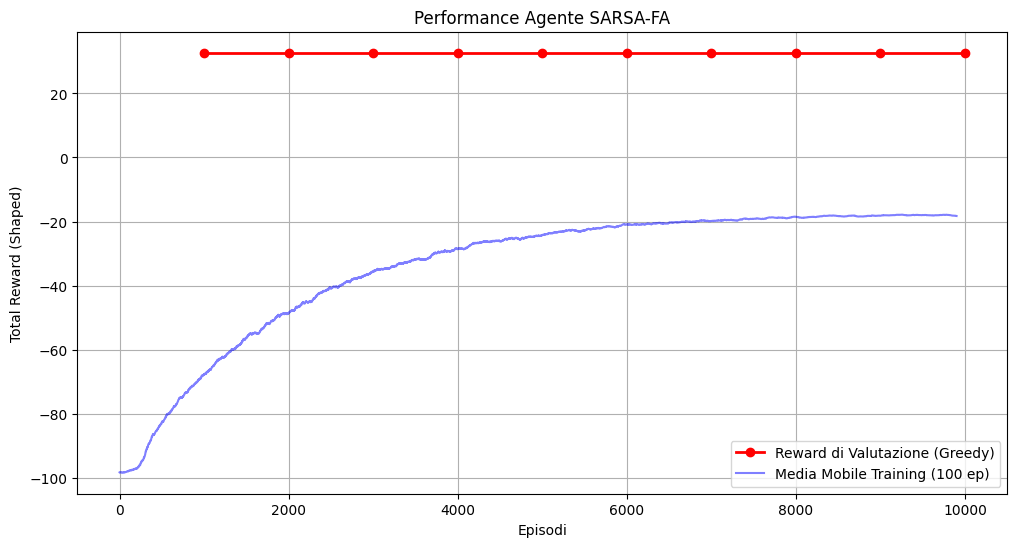

In [ ]:
train_rewards_moving_avg = moving_average(train_rewards, 100)

plt.figure(figsize=(12, 6))

plt.plot(eval_episodes_list, eval_rewards, label='Reward di Valutazione (Greedy)',
         color='red', linewidth=2, marker='o')

plt.plot(train_rewards_moving_avg, label='Media Mobile Training (100 ep)',
         color='blue', alpha=0.5)

plt.title('Performance Agente SARSA-FA')
plt.xlabel('Episodi')
plt.ylabel('Total Reward (Shaped)')
plt.legend()
plt.grid(True)
plt.show()

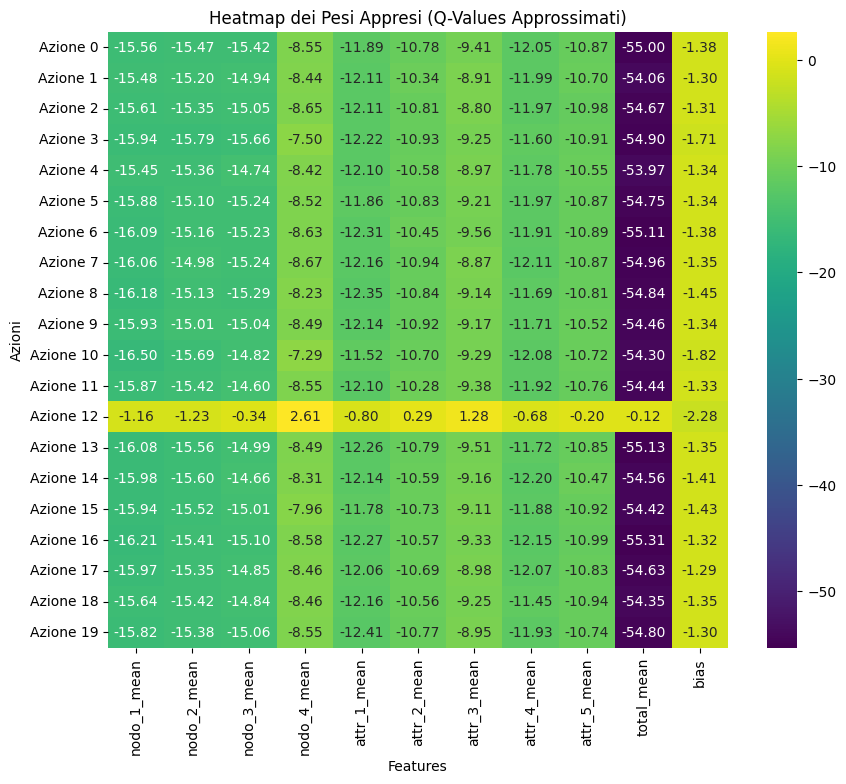

In [ ]:
import seaborn as sns

feature_names = [
    'nodo_1_mean', 'nodo_2_mean', 'nodo_3_mean', 'nodo_4_mean',
    'attr_1_mean', 'attr_2_mean', 'attr_3_mean', 'attr_4_mean', 'attr_5_mean',
    'total_mean', 'bias'
]

n_actions = sarsa_env.action_space.n
action_names = [f'Azione {i}' for i in range(n_actions)]

plt.figure(figsize=(10, 8))
sns.heatmap(
    weights,
    annot=True,
    fmt=".2f",
    xticklabels=feature_names,
    yticklabels=action_names,
    cmap='viridis'
)
plt.title('Heatmap dei Pesi Appresi (Q-Values Approssimati)')
plt.xlabel('Features')
plt.ylabel('Azioni')
plt.show()

# DDQN

In [ ]:
import torch.nn.functional as F

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        return (
            torch.FloatTensor(np.array(state)).to(DEVICE),
            torch.LongTensor(np.array(action)).unsqueeze(1).to(DEVICE),
            torch.FloatTensor(np.array(reward)).unsqueeze(1).to(DEVICE),
            torch.FloatTensor(np.array(next_state)).to(DEVICE),
            torch.FloatTensor(np.array(done)).unsqueeze(1).to(DEVICE)
        )

    def __len__(self):
        return len(self.buffer)

In [ ]:
ddqn_env = create_env("V21")
MEMORY_SIZE = config['ddqn']['memory_size'] if 'memory_size' in config['ddqn'] else 50000
LR = config['ddqn']['lr'] if 'lr' in config['ddqn'] else 0.0001
TAU = config['ddqn']['tau'] if 'tau' in config['ddqn'] else 0.005
BATCH_SIZE = config['ddqn']['batch_size'] if 'batch_size' in config['ddqn'] else 64
EPSILON_START = config['ddqn']['epsilon_start'] if 'epsilon_start' in config['ddqn'] else 1.0
EPSILON_END = config['ddqn']['epsilon_min'] if 'epsilon_min' in config['ddqn'] else 0.05
EPSILON_DECAY = config['ddqn']['epsilon_decay'] if 'epsilon_decay' in config['ddqn'] else 0.9995
N_FEATURES = 11
N_ACTIONS = ddqn_env.action_space.n


memory = ReplayBuffer(MEMORY_SIZE)

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
policy_net = QNetwork(N_FEATURES, N_ACTIONS).to(DEVICE)
optimizer = optim.Adam(policy_net.parameters(), lr=LR)

In [ ]:
class DDQNAgent:
    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions

        self.policy_net = QNetwork(n_states, n_actions).to(DEVICE)
        self.target_net = QNetwork(n_states, n_actions).to(DEVICE)

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayBuffer(MEMORY_SIZE)

        self.steps_done = 0
        self.epsilon = EPSILON_START

    def select_action(self, state):
        self.steps_done += 1
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

        if random.random() > self.epsilon:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                q_values = self.policy_net(state_t)
                return q_values.argmax(dim=1).item()
        else:
            return random.randrange(self.n_actions)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return 0.0

        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)
        current_q_values = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            best_next_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, best_next_actions)
            expected_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

        loss = F.smooth_l1_loss(current_q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(TAU * policy_param.data + (1.0 - TAU) * target_param.data)

        return loss.item()

In [ ]:
agent = DDQNAgent(n_states=N_FEATURES, n_actions=N_ACTIONS)

num_episodes = config['ddqn']['num_episodes'] if 'num_episodes' in config['ddqn'] else 1000
episode_rewards = []
losses = []

print(f"Avvio training DDQN su {DEVICE} per {num_episodes} episodi...")

for episode in range(num_episodes):
    raw_state = ddqn_env.reset(seed=episode)
    state = extract_state_features(raw_state)

    ep_reward = 0
    ep_loss = 0
    steps = 0

    for t in range(100):
        action = agent.select_action(state)
        next_raw_state, original_reward, done, info = ddqn_env.step(action)
        shaped_reward = shape_reward(raw_state, next_raw_state, original_reward, done, info)
        next_state = extract_state_features(next_raw_state)
        agent.memory.push(state, action, shaped_reward, next_state, done)
        loss = agent.optimize_model()

        state = next_state
        raw_state = next_raw_state
        ep_reward += shaped_reward
        ep_loss += loss
        steps += 1

        if done:
            break

    episode_rewards.append(ep_reward)
    losses.append(ep_loss / max(1, steps))

    if (episode + 1) % 50 == 0:
        avg_rew = np.mean(episode_rewards[-50:])
        print(f"Episode {episode+1} | Reward (last 50): {avg_rew:.2f} | Epsilon: {agent.epsilon:.3f} | Loss: {ep_loss:.4f}")

ddqn_env.close()

Avvio training DDQN su cuda per 1000 episodi...
Episode 50 | Reward (last 50): -55.04 | Epsilon: 0.082 | Loss: 3.9242
Episode 100 | Reward (last 50): -25.07 | Epsilon: 0.050 | Loss: 1.0652
Episode 150 | Reward (last 50): -23.07 | Epsilon: 0.050 | Loss: 0.7528
Episode 200 | Reward (last 50): -22.01 | Epsilon: 0.050 | Loss: 0.5051
Episode 250 | Reward (last 50): -22.15 | Epsilon: 0.050 | Loss: 0.4932
Episode 300 | Reward (last 50): -21.83 | Epsilon: 0.050 | Loss: 0.5260
Episode 350 | Reward (last 50): -27.46 | Epsilon: 0.050 | Loss: 0.5944
Episode 400 | Reward (last 50): -26.29 | Epsilon: 0.050 | Loss: 0.5998
Episode 450 | Reward (last 50): -26.02 | Epsilon: 0.050 | Loss: 0.5392
Episode 500 | Reward (last 50): -24.44 | Epsilon: 0.050 | Loss: 0.5575
Episode 550 | Reward (last 50): -23.41 | Epsilon: 0.050 | Loss: 0.2374
Episode 600 | Reward (last 50): -21.00 | Epsilon: 0.050 | Loss: 0.2282
Episode 650 | Reward (last 50): -21.77 | Epsilon: 0.050 | Loss: 0.2337
Episode 700 | Reward (last 50)

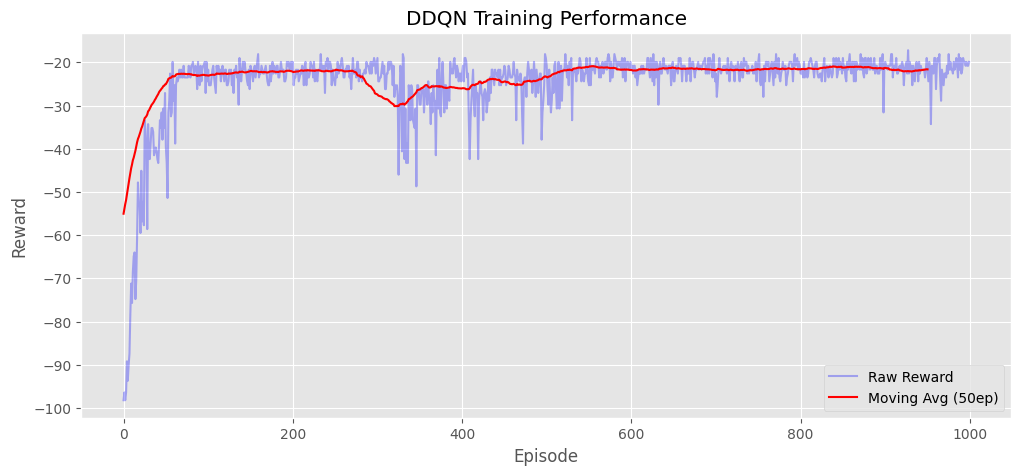

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, alpha=0.3, color='blue', label='Raw Reward')
plt.plot(moving_average(episode_rewards, window_size=50), color='red', label='Moving Avg (50ep)')
plt.title("DDQN Training Performance")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()